# Socc HAR - Training

Run the following cells to...
 * train or re-train a classifier with the SOCC-HAR-32 Datasets
 * re-evaluate a given classifier

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## 0. Setup

this step will...
  * fetch the source code
  * mount the video data to the VM
  * install the dependencies

You can follow the instruction in section **Colab** *or* in section **GCP** depending on the platform you are using right now!

### Colab

In [2]:
from google.colab import files
from pathlib import Path

uploaded = files.upload()

for filename in uploaded.keys():
  Path(filename).rename('id_rsa')
  assert Path('id_rsa').exists(), 'upload failed'

Saving id_rsa to id_rsa


👉 first of all you need to access the socc-har-toolkit repository. Therefore you need to upload your private SSH-Key. By running the following cell an upload promp will be shown. This is where your need to upload your SSH-Key!

In [3]:
%env SSH_KEY=/content/id_rsa
! chmod 400 $SSH_KEY
! GIT_SSH_COMMAND='ssh -i $SSH_KEY -o StrictHostKeyChecking=no -o IdentitiesOnly=yes' git clone git@gitlab.com:socc-har/socc-har-toolkit.git

env: SSH_KEY=/content/id_rsa
Cloning into 'socc-har-toolkit'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 746 (delta 29), reused 57 (delta 22), pack-reused 671
Receiving objects: 100% (746/746), 13.66 MiB | 21.19 MiB/s, done.
Resolving deltas: 100% (470/470), done.


In [4]:
assert Path('socc-har-toolkit').exists(), 'cloning the repository failed'

👉 Now you need to mount your whole Drive Storage to the VM by following the upcoming dialog:

In [5]:
from google.colab import drive
drive.mount('/content/drive')
assert Path('/content/drive').exists()

Mounted at /content/drive


⚠️ you can skip this step if you already did it **once**!

👉 you need to mount the video data stored in Google Drive to `socc-har-toolkit/data`.
Therefore you might got a public link to the content, which will navigate you to the `SOCC_HAR-32`-folder in Google Drive. Tap the folder and choose option `Add a shortcut to Drive` (like on the screenshot below) and link it to your personal Drive storage.

<style>img { width: 20px; }
</style>

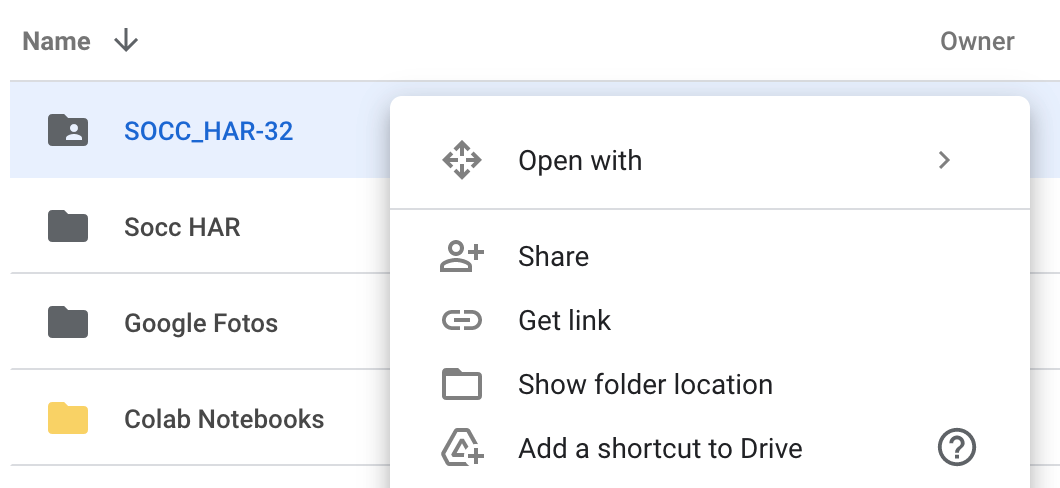

Your personal Drive Storage now is mounted to this VM, as you can see on the left-hand 'files'-tab in Colab under `/drive/MyDrive/` (see screenshot below)


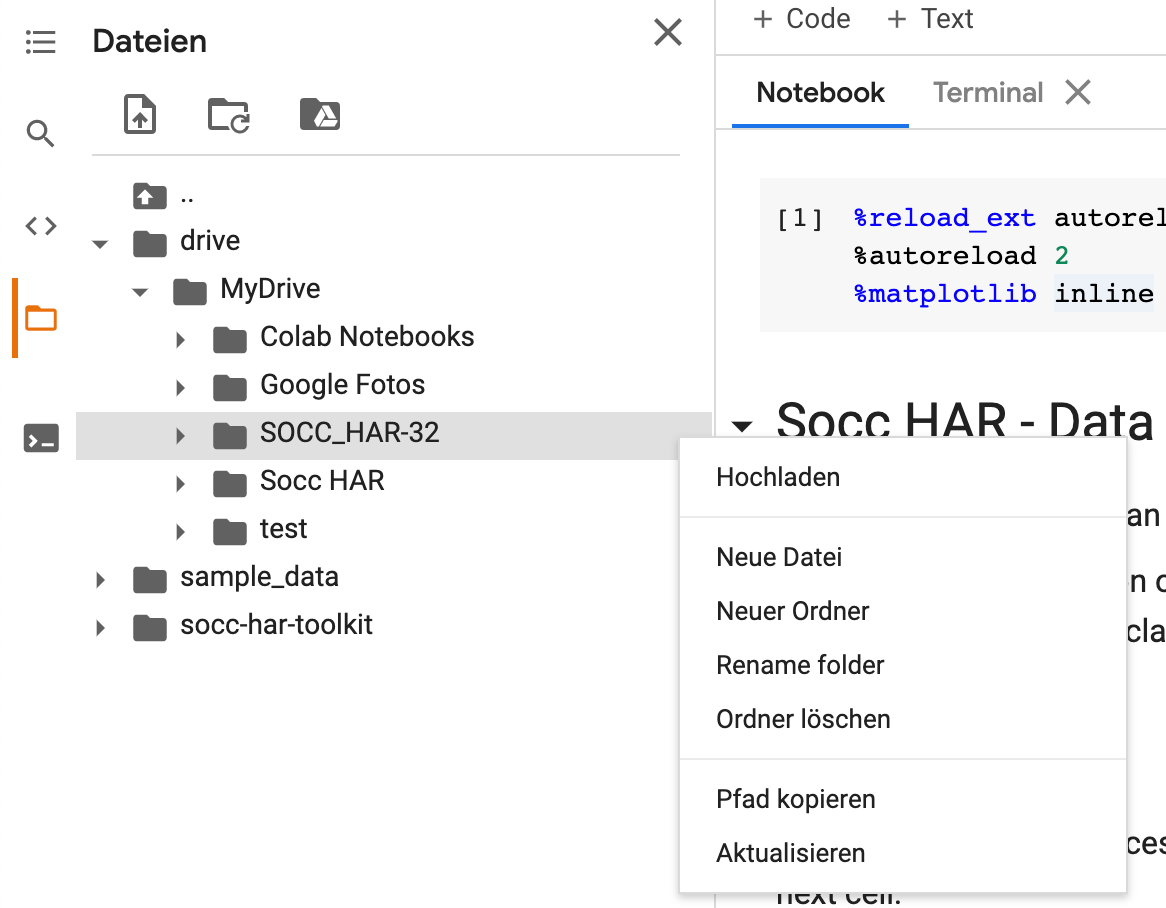

👉 Navigate to the SOCC_HAR-32-folder in the files tab (like in the screenshot above) and copy the path within the context menu shown in the above screenshot (`Pfad kopieren`). Then paste it into the following form under `data_mount_path` and run the cell

In [6]:
import re

data_mount_path = "/content/drive/MyDrive/SOCC_HAR-32" #@param {type:"string"}

match = re.match(r'^\/content\/drive\/MyDrive\/.*SOCC_HAR-32\/?$', data_mount_path)
assert bool(match), 'path should start with /content/drive/MyDrive and ends with the folder name of SOCC_HAR-32'

In [7]:
%env MOUNT_PATH=$data_mount_path

env: MOUNT_PATH=/content/drive/MyDrive/SOCC_HAR-32


⚠️ please run only **one** of the following code cells:

* **Option 1**: mounting video data (fast, but may slow down training time)
* **Option 2**: copying video data (this might take up to an hour, but improves training speed if you train a lot of epochs)

Option 1:

In [8]:
! mkdir /content/socc-har-toolkit/data
! ln -s $MOUNT_PATH/* /content/socc-har-toolkit/data

mkdir: cannot create directory ‘/content/socc-har-toolkit/data’: File exists


Option 2:

In [ ]:
! mkdir /content/socc-har-toolkit/data
! rsync -r --info=progress2 "$MOUNT_PATH/video/youtube" /content/socc-har-toolkit/data/video
! rsync -r --info=progress2 "$MOUNT_PATH/video/drive" /content/socc-har-toolkit/data/video

 47,622,673,701 100%   38.09MB/s    0:19:52 (xfr#131, to-chk=0/261)
 24,266,045,771 100%   38.21MB/s    0:10:05 (xfr#68, to-chk=0/137)


Now the content of `SOCC_HAR-32` should also appear in `socc-har-toolkit/data`

In [9]:
assert Path('/content/socc-har-toolkit/data/video/youtube').exists(), 'Your mount may exists, but is invalid'

In [10]:
%cd /content/socc-har-toolkit
! GIT_SSH_COMMAND='ssh -i ../id_rsa -o StrictHostKeyChecking=no -o IdentitiesOnly=yes' git fetch
! GIT_SSH_COMMAND='ssh -i ../id_rsa -o StrictHostKeyChecking=no -o IdentitiesOnly=yes' git reset --hard origin/master

/content/socc-har-toolkit
HEAD is now at 440c6ea No sampler for testing


### GCP

In [ ]:
! gcsfuse soccer-action-classification-data /home/jupyter/socc-har-toolkit/data

### Install dependencies

finally install all needed dependencies:

In [11]:
! pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html
! pip install pytorch_lightning==1.1.2
! pip install av
! pip install matplotlib
! pip install git+https://gitlab.com/obuilds/public/pytube@ob-v1 # fork of pytube3
! pip install -U --no-cache-dir gdown --pre
! pip install comet_ml
! pip install celluloid
! pip install mmaction2==0.9.0
! pip install mmcv
! pip install fvcore

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.4MB 23kB/s 
     |████████████████████████████████| 12.8MB 5.9MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101
     |████████████████████████████████| 675kB 5.3MB/s 
     |████████████████████████████████| 102kB 7.8MB/s 
     |████████████████████████████████| 829kB 10.9MB/s 
     |████████████████████████████████| 276kB 19.2MB/s 
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=2c1b4dd7cff5f6128ee00a03192dc22259d9cba005683039f6f957a4d2d4ef9f
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for PyYAML: filename=PyYAML-5.3.1-c

In [12]:
import torch
assert torch.cuda.is_available()
%cd /content/socc-har-toolkit/

/content/socc-har-toolkit


## 1. Pick an (pre-trained) experiment

In [13]:
%cd /content/socc-har-toolkit/

/content/socc-har-toolkit


In [14]:
from socc_har.data import MediaDir, DatabaseHandle, DataModule
from socc_har.util.storage import Storage, StoredExperiment, benchmarks
from socc_har.eval import EvaluationModule
from socc_har.eval.database_transactions import Transactions
from socc_har.eval.widgets.relabeler import Relabeler
from socc_har.train import TrainLogger, Classifier
import torch
import pandas as pd
from socc_har.util import storage

/usr/local/lib/python3.6/dist-packages/mmcv/utils/registry.py:64: UserWarning: The old API of register_module(module, force=False) is deprecated and will be removed, please use the new API register_module(name=None, force=False, module=None) instead.
  'The old API of register_module(module, force=False) '
/usr/local/lib/python3.6/dist-packages/mmaction/models/backbones/resnet_tin.py:12: UserWarning: Please install mmcv-full to support "tin_shift"
  warnings.warn('Please install mmcv-full to support "tin_shift"')


In [15]:
pretrained_path = None
report_path = None
storage = Storage()
storage.widget()

In [16]:
exp = StoredExperiment(storage.experiment_path)

pretrained_path = exp.get_checkpoints()
report_path = exp.get_report()
print(pretrained_path)
print(report_path)

download ckpt from narendorf/soccar-32-ph1/822944fc50984cc99ee96586ec15e9f1
download report from narendorf/soccar-32-ph1/822944fc50984cc99ee96586ec15e9f1
narendorf_soccar-32-ph1_822944fc50984cc99ee96586ec15e9f1.ckpt
narendorf_soccar-32-ph1_822944fc50984cc99ee96586ec15e9f1.csv


Hyperparameter:

In [17]:
hparams = torch.load(pretrained_path, map_location=torch.device('cpu'))['hyper_parameters']
hparams

{'accumulate_grad_batches': 8,
 'batch_size': 8,
 'consensus': 'max',
 'epochs': 10,
 'fps': 12,
 'lr': [3e-06, 0.003],
 'mean': [0.37409, 0.44932, 0.30282],
 'name': 'irCSN_152',
 'num_frames': 32,
 'optim': 'adam',
 'pretrained_path': PosixPath('narendorf_soccar-32-pho_9a7c4b4803de43a7b15b3678cd32e3c0.ckpt'),
 'res': 224,
 'scheduler': 'cycle',
 'std': [0.01051, 0.01055, 0.01259],
 'trainable_groups': 4,
 'weight_decay': 0.0001}

## 2. Initialize Data Module

In [19]:
#@title Storage
dataset = "socc-har-32-v0.1.1" #@param ["socc-har-32-v0.1.1", "socc-har-32-v0.3.3"]

data_path = "./data"
out_path = "./data/out" #@param {type:"string"}
metadata_path = "/content/drive/MyDrive/SOCC_HAR-32/video_metadata/colab.pt" #@param {type:"string"}



In [52]:
#@title Sampling

fps = 9 #@param {type: "slider", min:4, max:25, step: 1}
num_frames = 24 #@param {type:"slider", min:8, max:96, step:8}
res = 224 #@param {type:"slider", min:112, max:312, step:8}
max_train_samples_per_class = 100 #@param {type:"slider", min:10, max:1000, step:5}
num_workers = 12 #@param {type:"slider", min:4, max:16, step:4}

f'duration of clips: {num_frames/fps:.2f} sec'

'duration of clips: 2.67 sec'

**Todo**: Dropdown Widget with all exps

In [21]:
#@title Pre-trained models
new = True #@param {type:"boolean"}


**Todo**: store report in out_dir! each epoch!

In [22]:
#@title Architecture
from socc_har.arch import C3D, irCSN_152, R2Plus1D_34, SlowFast4x16_50, SlowFast8x8_50
from socc_har.arch.x3d import X3D_S, X3D_M
from socc_har.arch.x3d_alt import X3D_L

arch = irCSN_152 #@param ["C3D", "irCSN_152", "R2Plus1D_34", "SlowFast4x16_50", "SlowFast8x8_50", "X3D_L"] {type:"raw"}
arch = arch(num_classes=32)

In [28]:
#@title Storage

project = "narendorf/socc-har-32" #@param ["narendorf/soccar-32", "narendorf/socc-har-32"]
phase = "Ph1" #@param ["Ph0", "Ph1", "Ph2"]

In [29]:
#@title Classifier

epochs = 3 #@param {type:"slider", min:1, max:10, step:1}
weight_decay = 1.0E-45 #@param {type:"number"}
optim = "adam" #@param ["adam", "sgd"]
scheduler = "cycle" #@param ["cosine", "cycle", "plateau"]
consensus = "max" #@param ["avg", "max"]
patience = 10 #@param {type:"slider", min:2, max:10, step:1}
precision = 16 #@param {type:"slider", min:16, max:32, step:16}
trainable_groups = 6 #@param {type:"slider", min:1, max:6, step:1}

In [30]:
#@title Pre-trained stats
SoccHAR32 = dict(mean=[0.37409, 0.44932, 0.30282], std=[0.01051, 0.01055, 0.01259])
Kinetics = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
Kinetics_x3d = dict(mean=[0.45, 0.45, 0.45], std=[0.225, 0.225, 0.225])
Sports1M = dict()
VMZ = dict(mean=[0.43216, 0.394666, 0.37645], std=[0.22803, 0.22145, 0.216989])

pretrained_stats = SoccHAR32 #@param ["Kinetics", "VMZ", "SoccHAR32"] {type:"raw"}

In [31]:
id = f'{hparams["name"]}_{num_frames}T_{fps}fps'
id

'irCSN_152_24T_9fps'

In [32]:
project_name = f"{project}-{phase}"

if new:
    logger = TrainLogger(id, project_name)
else:
    logger = TrainLogger.from_existing_run(storage.experiment_path)

CometLogger will be initialized in online mode
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/narendorf/socc-har-32-ph1/27cbbf3e22f842e48e75ec5bdec19d3b



In [33]:
import math
duration = hparams['num_frames'] / hparams['fps']
test_duration = 6

num_test_crops = math.ceil(test_duration * 1.5 / duration)

f'''test with {num_test_crops} temporal crops'''

'test with 4 temporal crops'

In [53]:
dm = DataModule(database=dataset,
                data_dir=data_path, out_dir=out_path,
                num_frames=num_frames,
                res=res, fps=fps, batch_size=8,
                num_data_workers=num_workers,
                max_train_samples_per_class=max_train_samples_per_class,
                metadata_path=metadata_path,
                test_duration=test_duration,
                num_test_crops=num_test_crops,
                num_test_frames=None)

In [54]:
dm.max_train_samples_per_class

100

In [55]:
dm.prepare_data(verbose=False)

found precomputed video metadata.


/content/socc-har-toolkit/socc_har/data/pre_processing.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  video_metadata[split]['video_pts'].append(torch.tensor(pts))



all videos found


In [56]:
dm.setup('fit')

collecting samples



sample 3157/440108 clips
collecting samples



sample 1377/57521 clips


In [57]:
from pathlib import Path

if new:
    module = Classifier(backbone=arch, 
                        num_frames=num_frames, res=res, fps=fps,
                        trainable_groups=trainable_groups,
                        epochs=epochs,
                        weight_decay=weight_decay, precision=precision, optim=optim,
                        scheduler=scheduler, patience=patience,
                        pretrained_path=pretrained_path,
                        num_classes=dm.num_classes,
                        mean=pretrained_stats['mean'], std=pretrained_stats['std'],
                        train_samples=dm.num_train_samples
                        )
else:
    module = Classifier.load_from_checkpoint(str(pretrained_path),
                                             backbone=arch,
                                             num_classes=dm.num_classes,
                                             train_samples=dm.num_train_samples)

all weights loaded


In [58]:
module.unfreeze_layers(groups=module.hparams.trainable_groups)
module.summarize(mode='top')

  | Name     | Type        | Params
-----------------------------------------
0 | backbone | ResNet3dCSN | 28.9 M
1 | cls_head | I3DHead     | 65.6 K
-----------------------------------------
28.9 M    Trainable params
0         Non-trainable params
28.9 M    Total params

In [59]:
module.trainable_layers[0]

[I3DHead(
   (loss_cls): CrossEntropyLoss()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc_cls): Linear(in_features=2048, out_features=32, bias=True)
   (avg_pool): AdaptiveAvgPool3d(output_size=(1, 1, 1))
 )]

## 2. Find Maximum Batch size

In [60]:
max_batch_size =  7#@param {type:"number"}

scale the batch size...

In [61]:
from pytorch_lightning import Trainer

if not max_batch_size:
    trainer = Trainer(auto_scale_batch_size='binsearch', #'power',
                      gpus=1,
                      num_sanity_val_steps=0,
                      progress_bar_refresh_rate=100
                      )

    trainer.tune(module, datamodule=dm)
    max_batch_size = dm.batch_size

module.hparams.batch_size = max_batch_size

multi_clip_test_bs = math.floor(max_batch_size / (num_test_crops))
f'batch size for training is {module.train_bs}, for testing is {multi_clip_test_bs}, maximum is {module.hparams.batch_size}, accumulate gradients is {module.accumulate_grad_batches}'

'batch size for training is 4, for testing is 1, maximum is 7, accumulate gradients is 16'

## 3. Find LRs

### find lr

In [ ]:
from pytorch_lightning import Trainer

dm.batch_size = module.train_bs
trainer = Trainer(accumulate_grad_batches=module.accumulate_grad_batches,
                  gpus=1,
                  num_sanity_val_steps=0,
                  progress_bar_refresh_rate=20
                  )

# Run learning rate finder
lr_finder = trainer.tuner.lr_find(module, min_lr=1e-09, max_lr=3e-01,
                                  early_stop_threshold=4.0,
                                  datamodule=dm,
                                  num_training=100)
# Results can be found in
results = lr_finder.results

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


sample 6064.0/440161 random clips


/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."
/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."
/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."
/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."
/usr/local/lib/python3.6/dis

mmco: unref short failure
mmco: unref short failure
mmco: unref short failure
mmco: unref short failure
mmco: unref short failure
mmco: unref short failure
mmco: unref short failure
mmco: unref short failure
mmco: unref short failure
mmco: unref short failure
mmco: unref short failure
mmco: unref short failure
 (repeated 2 more times)
Missing reference picture, default is 65530
Missing reference picture, default is 65530
mmco: unref short failure
mmco: unref short failure
 (repeated 2 more times)
Missing reference picture, default is 65530
Missing reference picture, default is 65530
mmco: unref short failure
mmco: unref short failure
/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."
/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong res

suggest lr=4.417353340696639e-06


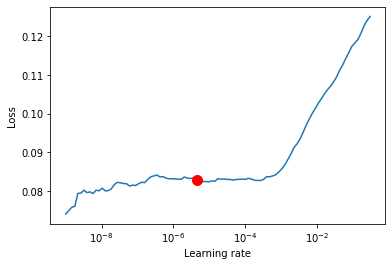

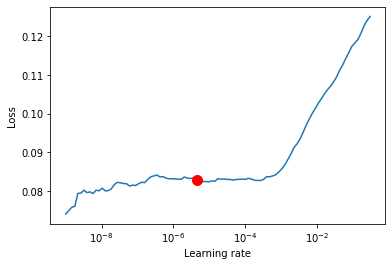

In [ ]:
# Pick point based on plot, or get suggestion
best_lr = lr_finder.suggestion()
print(f'suggest lr={best_lr}')

# Plot with
fig = lr_finder.plot(suggest=True)

logger.experiment.log_figure(figure_name='LR Finder', figure=fig)

fig

In [ ]:
lr_finder.suggestion(20, 20)

4.417353340696639e-06

### define lr range

$\to$ set `lr=[min_lr, max_lr]` for trainig multile layers or `lr=[best_lr]` for just adjusting the `fc`-layer. the max lr should be the steepest point or the lowest point divided by 10. the min lr should not be lower than the first step loss is going down

In [62]:
min_lr = 3e-06 #@param {type:"number"}
max_lr = 3e-04 #@param {type:"number"}

assert min_lr <= max_lr
assert max_lr < 1

module.hparams.lr = [min_lr, max_lr]

module.lrs

array([3.00000000e-04, 1.19432151e-04, 4.75467958e-05, 1.89287203e-05,
       7.53565929e-06, 3.00000000e-06])

## 4. Logging


In [63]:
logger.experiment.log_text(text=str(module.summarize()), metadata={'type': 'summary'})

logger.log_hyperparams(module.hparams)

logger.experiment.log_text(text=str(arch), metadata={'type': 'graph'})

{'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=e2dcdc8526ef4f58ab84497fee6bb7f6&experimentKey=27cbbf3e22f842e48e75ec5bdec19d3b',
 'assetId': 'e2dcdc8526ef4f58ab84497fee6bb7f6',
 'web': 'https://www.comet.ml/api/asset/download?assetId=e2dcdc8526ef4f58ab84497fee6bb7f6&experimentKey=27cbbf3e22f842e48e75ec5bdec19d3b'}

In [64]:
eval = EvaluationModule(out_path, dm, logger, img_format=['eps', 'png'])


In [65]:
dm.max_train_samples_per_class

100

### log a few data statistics...

In [66]:
import torch
annos = torch.sum(torch.tensor([dm.stats[context].actions for context in ['train', 'val']]), dim=0).tolist()
distri = dict(zip(dm.classes, annos))
logger.experiment.log_text(text=distri, metadata={'type': 'classes'})

{'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=2166f7f3fa1649609bdb474a31f360b4&experimentKey=27cbbf3e22f842e48e75ec5bdec19d3b',
 'assetId': '2166f7f3fa1649609bdb474a31f360b4',
 'web': 'https://www.comet.ml/api/asset/download?assetId=2166f7f3fa1649609bdb474a31f360b4&experimentKey=27cbbf3e22f842e48e75ec5bdec19d3b'}

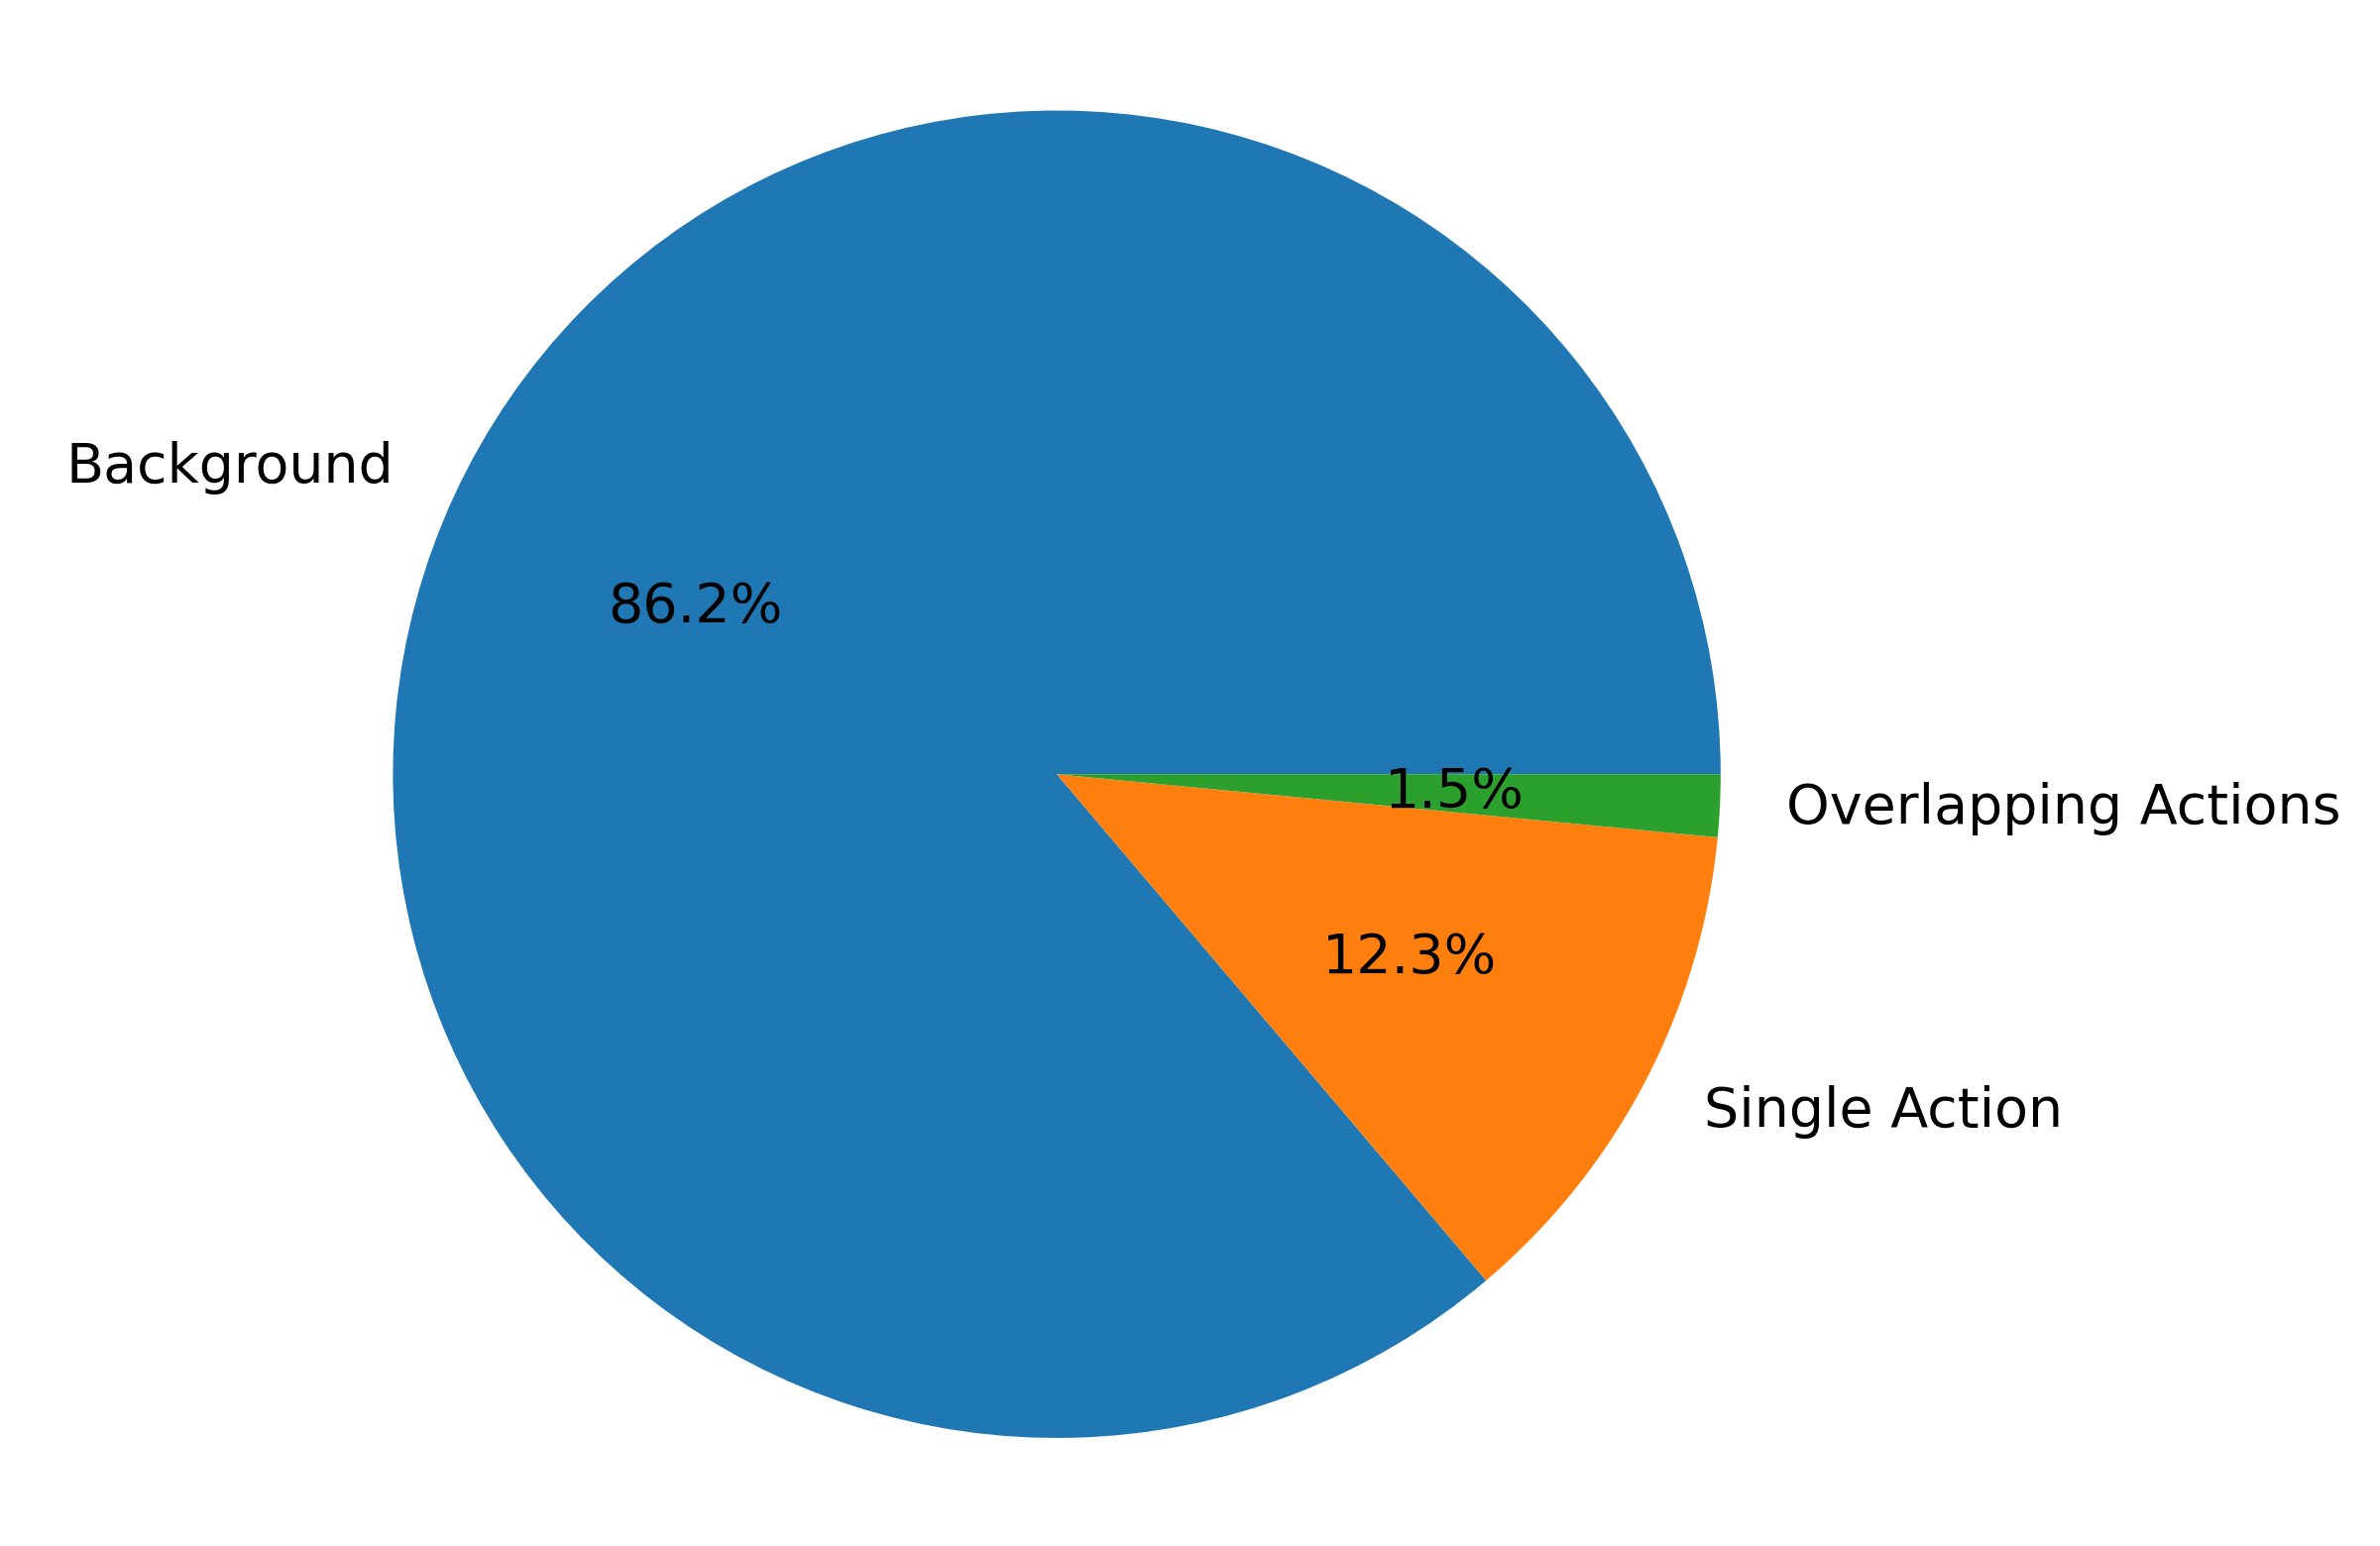

In [67]:
fig = eval.plot_background_ratio(context='train', save=True, upload=True)
fig

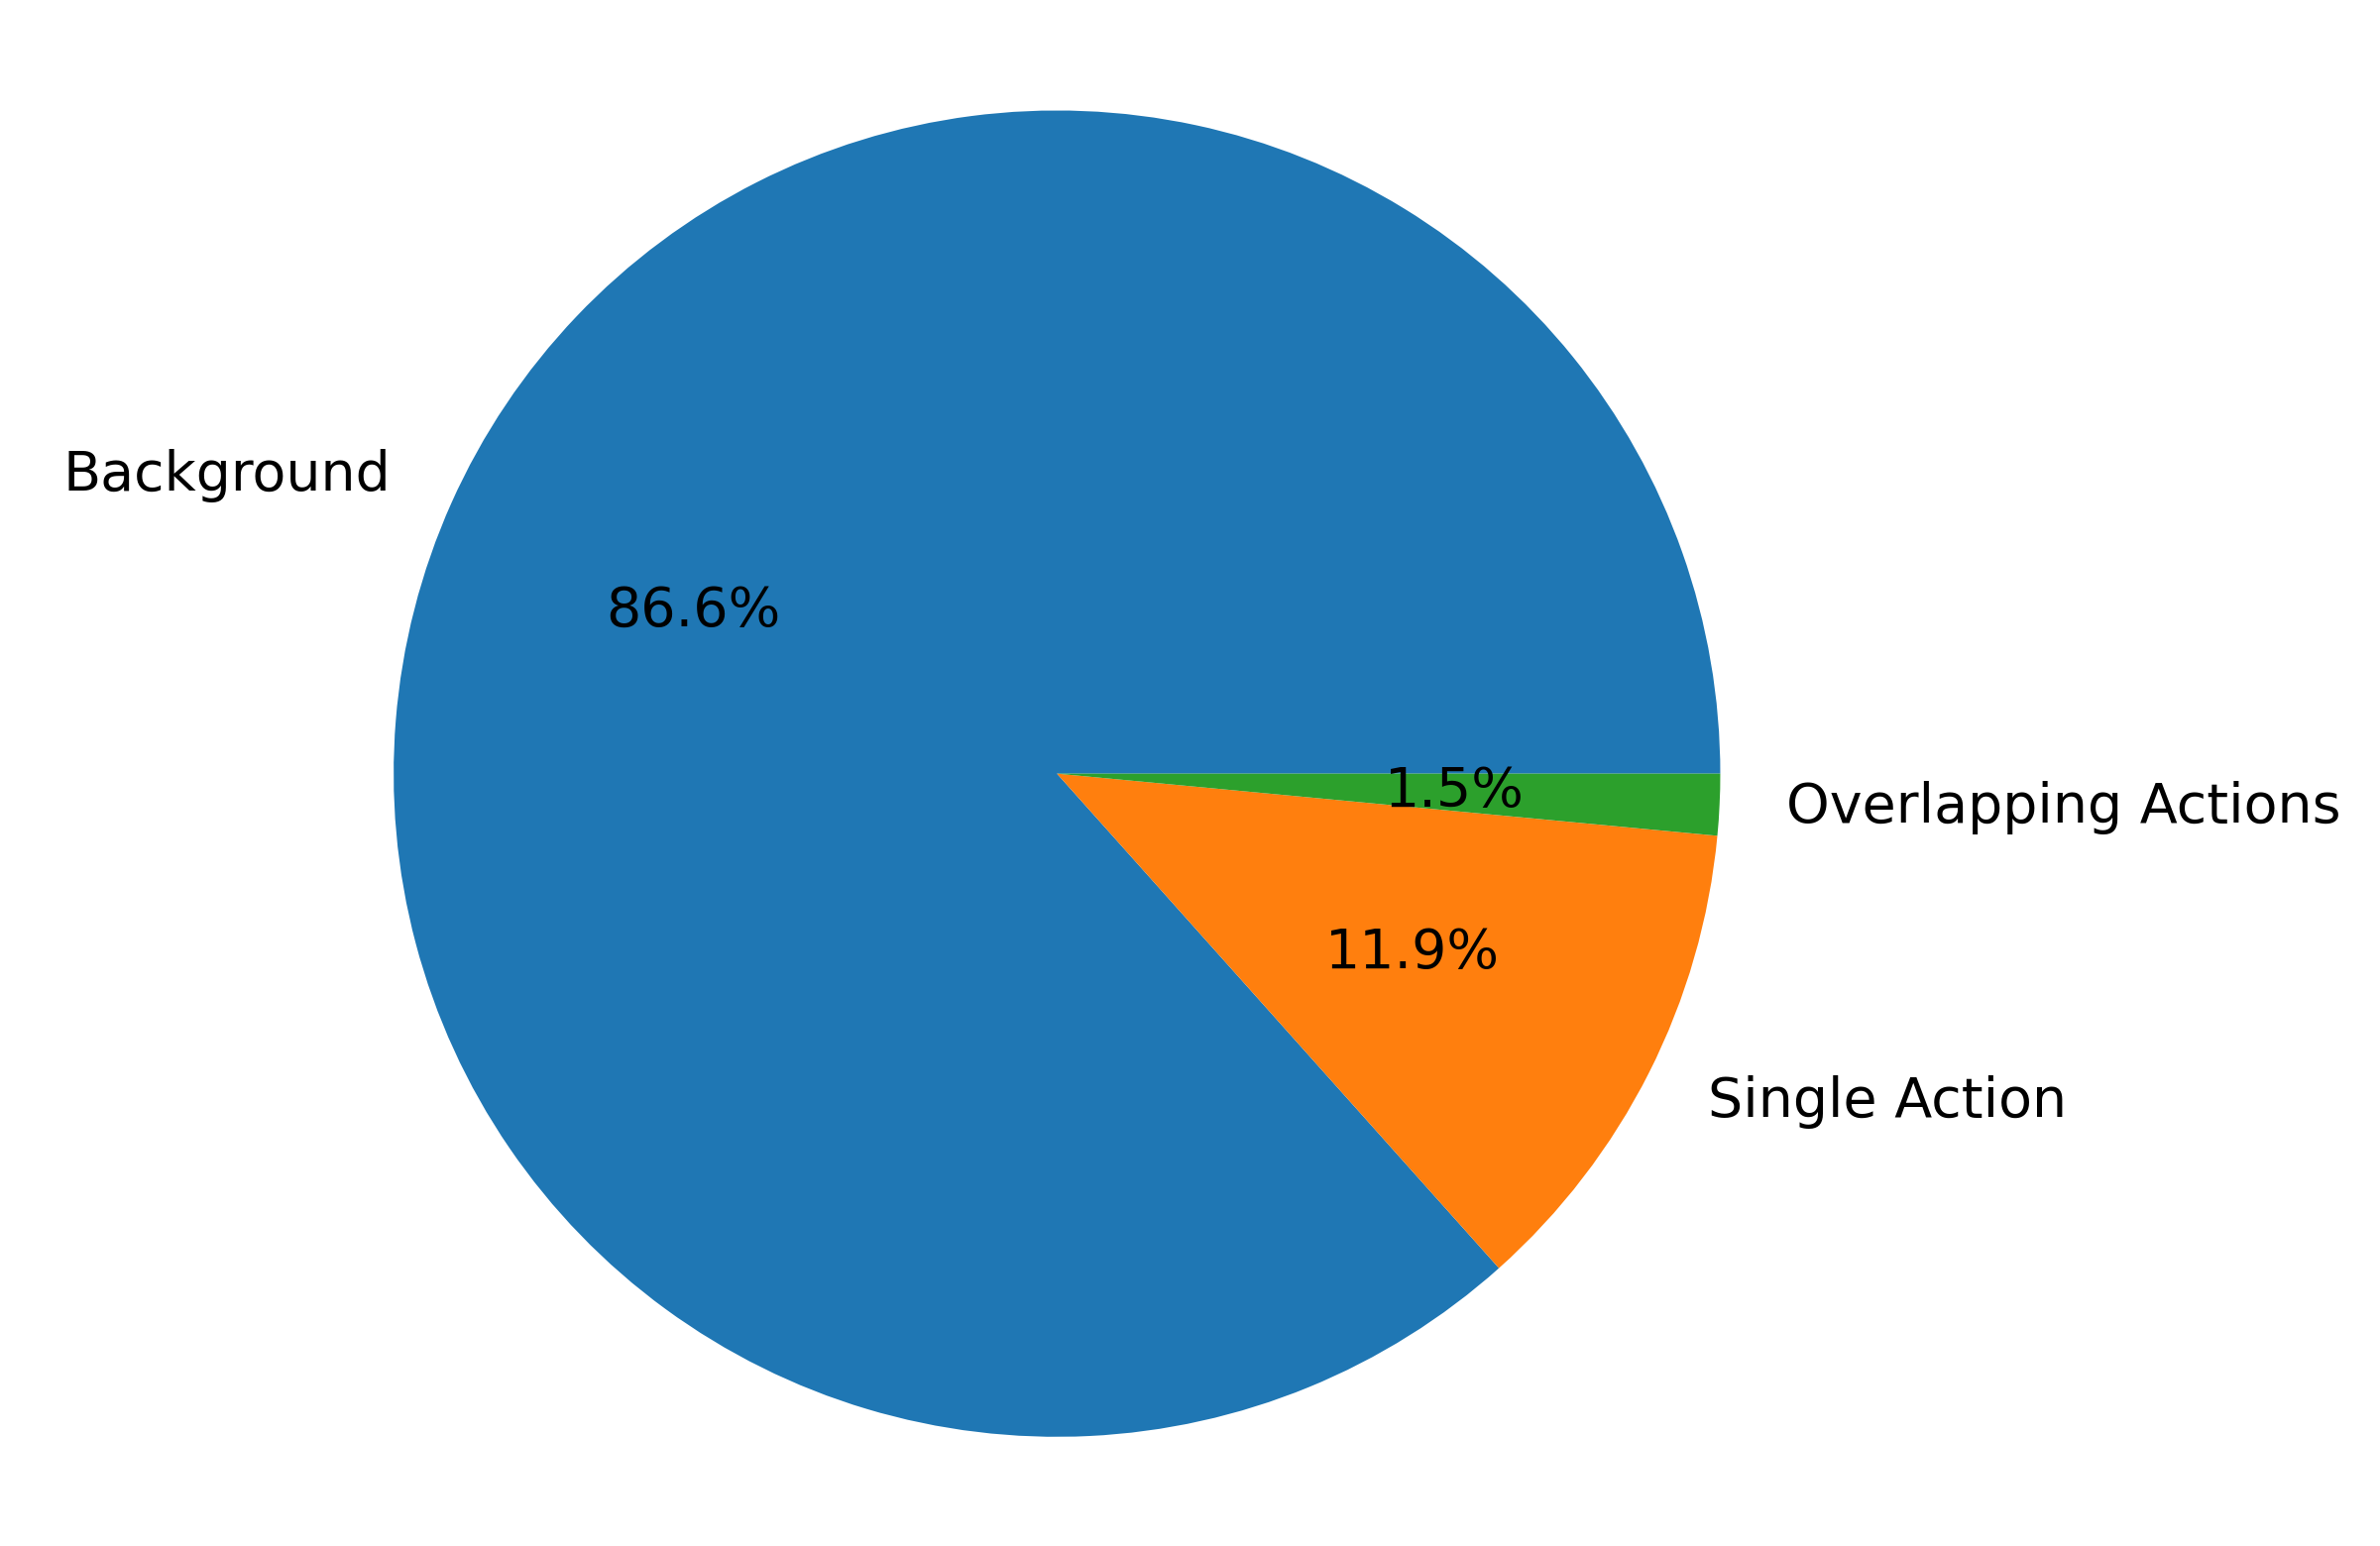

In [49]:
fig = eval.plot_background_ratio(context='val', save=True, upload=True)
fig

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


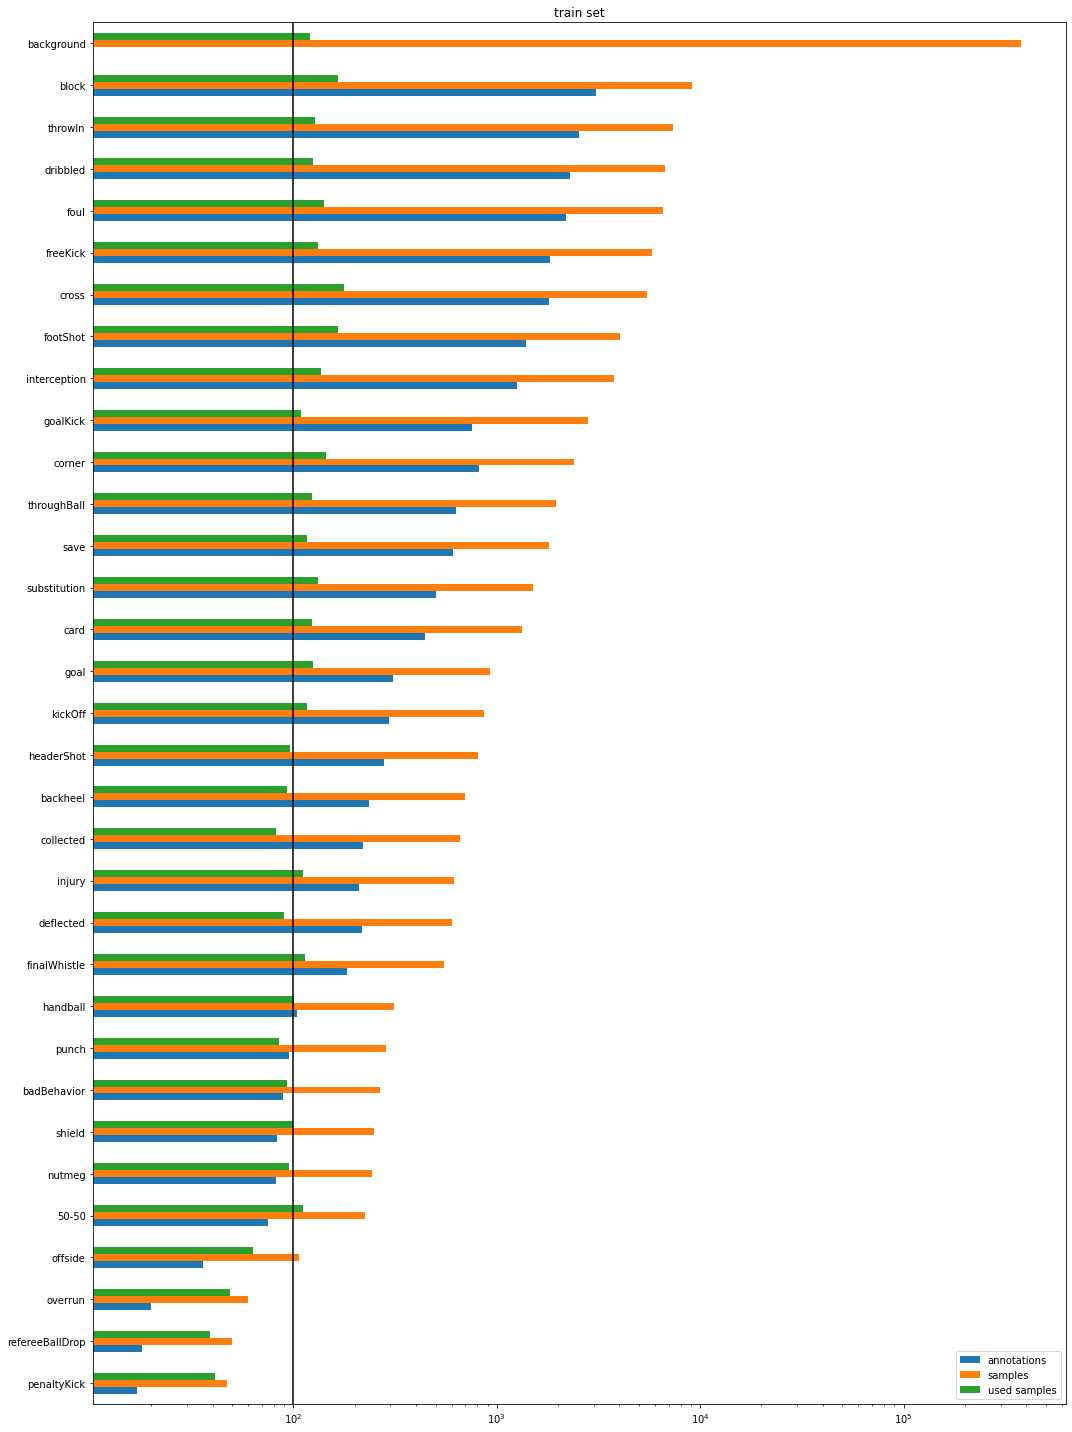

In [68]:
eval.plot_distribution(context='train', save=True, upload=True)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


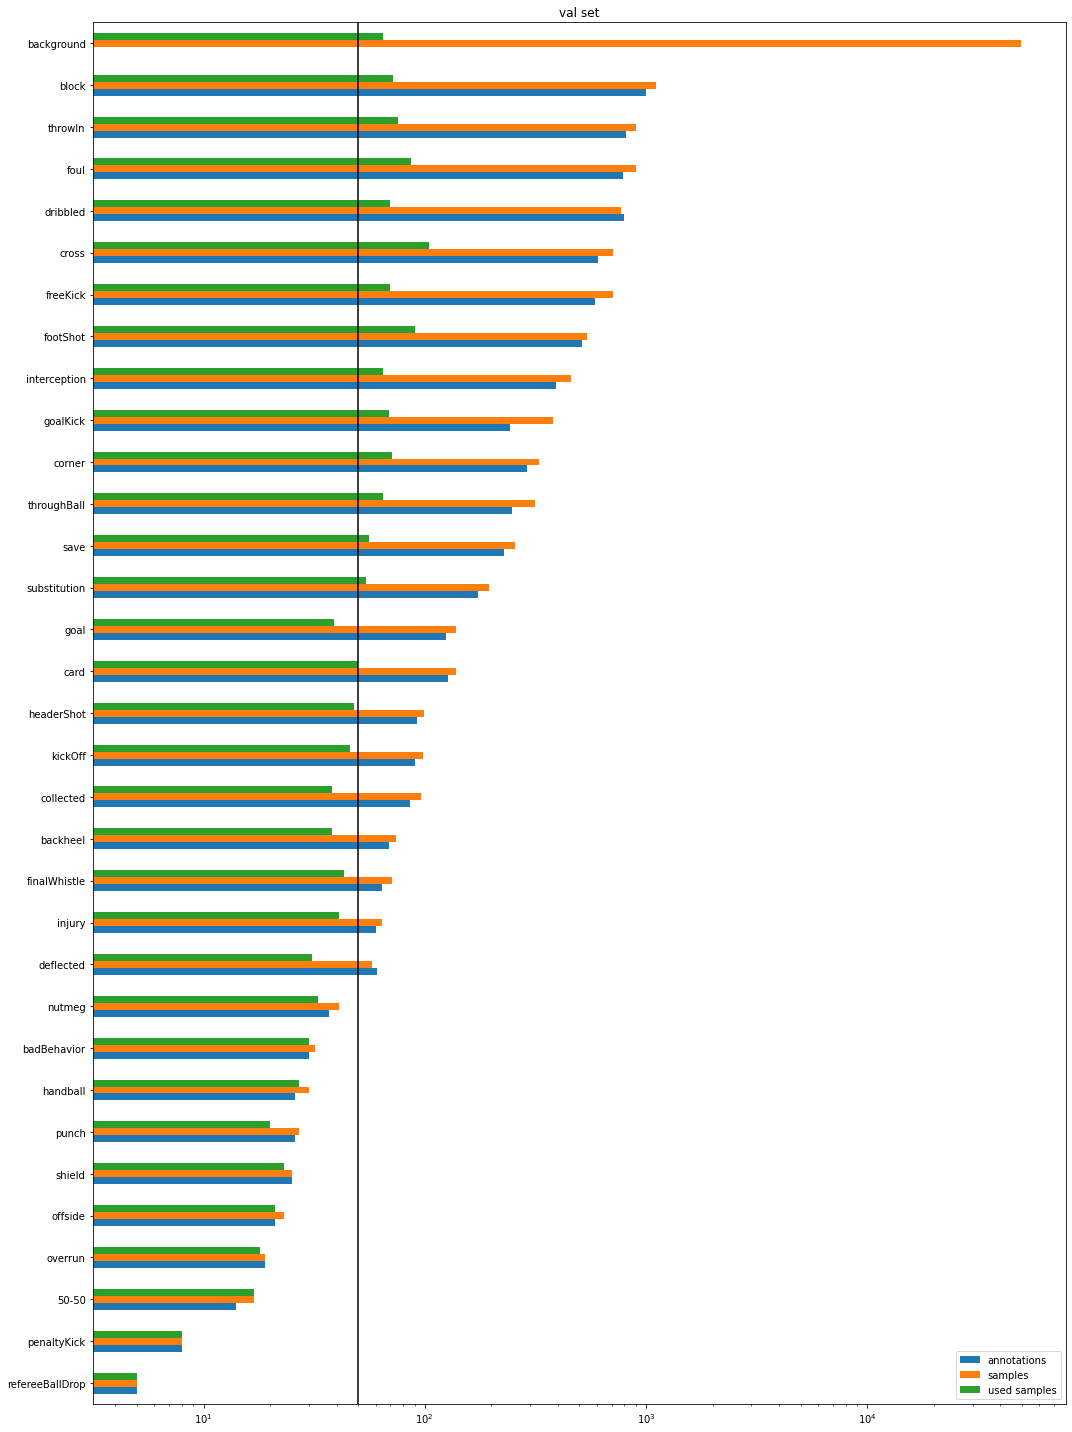

In [48]:
eval.plot_distribution(context='val', save=True, upload=True)


plot a random sample...

In [50]:
from ipywidgets import HTML
plot = eval.get_sample_plot(context='train')
HTML(plot.show('sample'))

row set to 434972 by random choice


HTML(value='<video width="864" height="576" controls autoplay loop>\n  <source type="video/mp4" src="data:vide…

In [69]:
plot.save('png')
plot.save('gif')

COMET ERROR: We failed to read file data/out/samples/CYdcNu6L@2:2484.0-2486.7.png for uploading.
Please double-check the file path and permissions


PosixPath('data/out/samples/CYdcNu6L@2:2484.0-2486.7.gif')

In [70]:
plot = eval.get_sample_plot(context='val')
HTML(plot.show('sample'))

row set to 24196 by random choice


HTML(value='<video width="864" height="576" controls autoplay loop>\n  <source type="video/mp4" src="data:vide…

In [71]:
plot.save('gif')
plot.save('svg')

PosixPath('data/out/samples/9717@2:3397.3-3400.0.svg')

## 5. Train

 * **TODO** eventually re-init classifier if lr monitor grows exponential after lr_find (**if lr_find throws an error, it gets in invalid state**)

In [72]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from socc_har.train.callbacks.reporter import Reporter
from pathlib import Path
import pandas as pd

reporter = Reporter(Path(out_path).joinpath(id), dm.classes, df=pd.read_csv(report_path) if new == False and report_path else None)
lr_logger = LearningRateMonitor(logging_interval='step')

checkpoints = ModelCheckpoint(monitor='val_auroc_macro',
                              dirpath=str(Path(out_path).joinpath(module.id)),
                              prefix='',
                              save_top_k=3,
                              mode='max',
                              verbose=True)

trainer = Trainer(accumulate_grad_batches=module.accumulate_grad_batches, # active in real life training
                  auto_lr_find=False, # not needed because it is called explicitly
                  automatic_optimization=True,
                  #auto_scale_batch_size='power',
                  #benchmark=True, # active in train/val-loops -> will speedup gpu
                  callbacks=[reporter, lr_logger],
                  checkpoint_callback=checkpoints,
                  #fast_dev_run=True,
                  flush_logs_every_n_steps=100,
                  gpus=1,
                  #gradient_clip_val=0.5, # active if gradient vanish or explode
                  #limit_val_batches=10, # active for testing
                  log_every_n_steps=1, # default is 50
                  logger=logger,
                  max_epochs=module.hparams.epochs,
                  #max_steps=30,
                  num_sanity_val_steps=0,  # no test run
                  #overfit_batches=0.01,  # activate for testing
                  precision=precision,
                  #profiler="simple", # active to see bottlenecks
                  #profiler="advanced", # active to see bottlenecks
                  progress_bar_refresh_rate=50,
                  reload_dataloaders_every_epoch=True,
                  resume_from_checkpoint=str(pretrained_path) if not new else None,
                  #tpu_cores=1,
                  #track_grad_norm=2, # -1,  # 2
                  weights_summary='top',
                  #working_dir=Path('dist'),
                  )


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Disable automatic optimization with the trainer flag is deprecated and will be removed in v1.3.0!Please use the property on the LightningModule for disabling automatic optimization
  warnings.warn(*args, **kwargs)
Using native 16bit precision.


In [73]:
from pytorch_lightning import seed_everything

seed_everything(21012021)

21012021

In [74]:
module.train_bs

4

In [ ]:
#dm.num_data_workers = 0
dm.batch_size = module.train_bs
trainer.fit(module, datamodule=dm)

sample 3157.0/440108 random clips


/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."
/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."
/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."
/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."
/usr/local/lib/python3.6/dis

upload best checkpoints...

In [ ]:
f'best checkpoints at {checkpoints.best_model_path}'

In [ ]:
ckpt_path = Path(checkpoints.best_model_path)
res = logger.experiment.log_asset(ckpt_path)
res

upload report...

In [ ]:
report_path = reporter.report_file
f'saved report at {report_path}'

In [ ]:
res = logger.experiment.log_asset(report_path)
res

## 6. Test



### Get data

index test data...

In [ ]:
dm.setup('test')

collecting samples



sample 2345/27598 clips


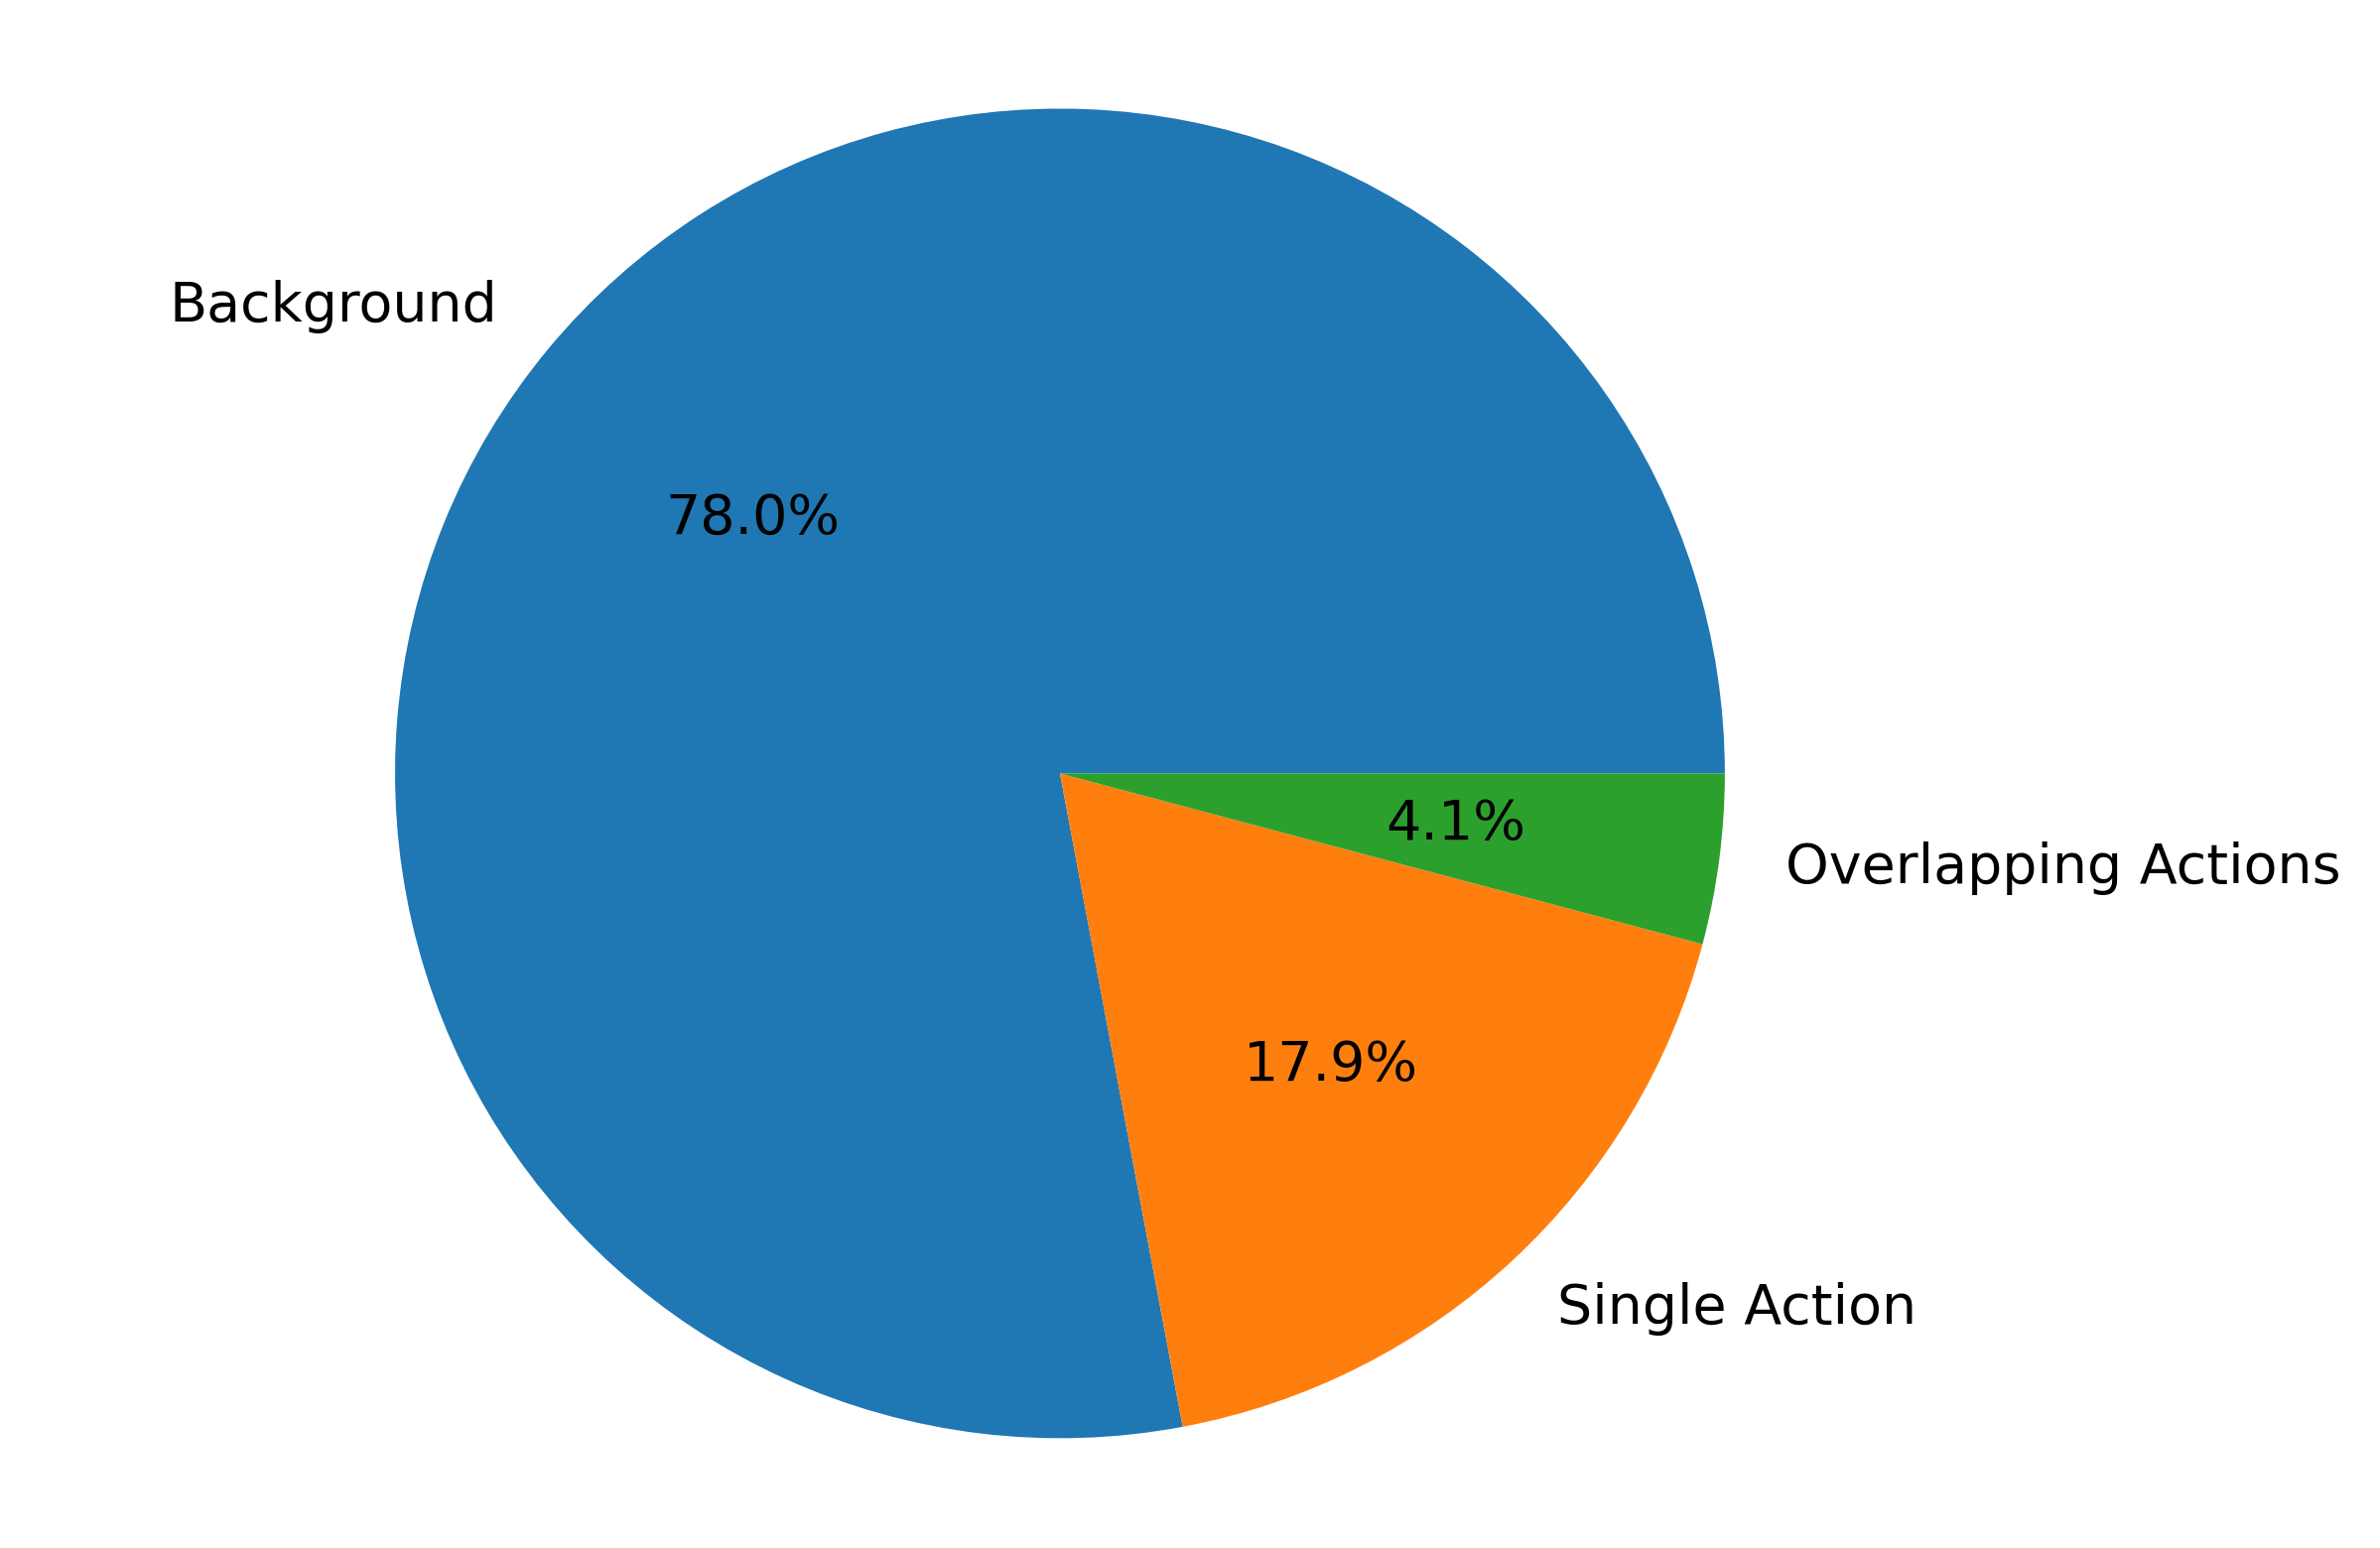

In [ ]:
fig = eval.plot_background_ratio(context='test', save=True, upload=True)
fig

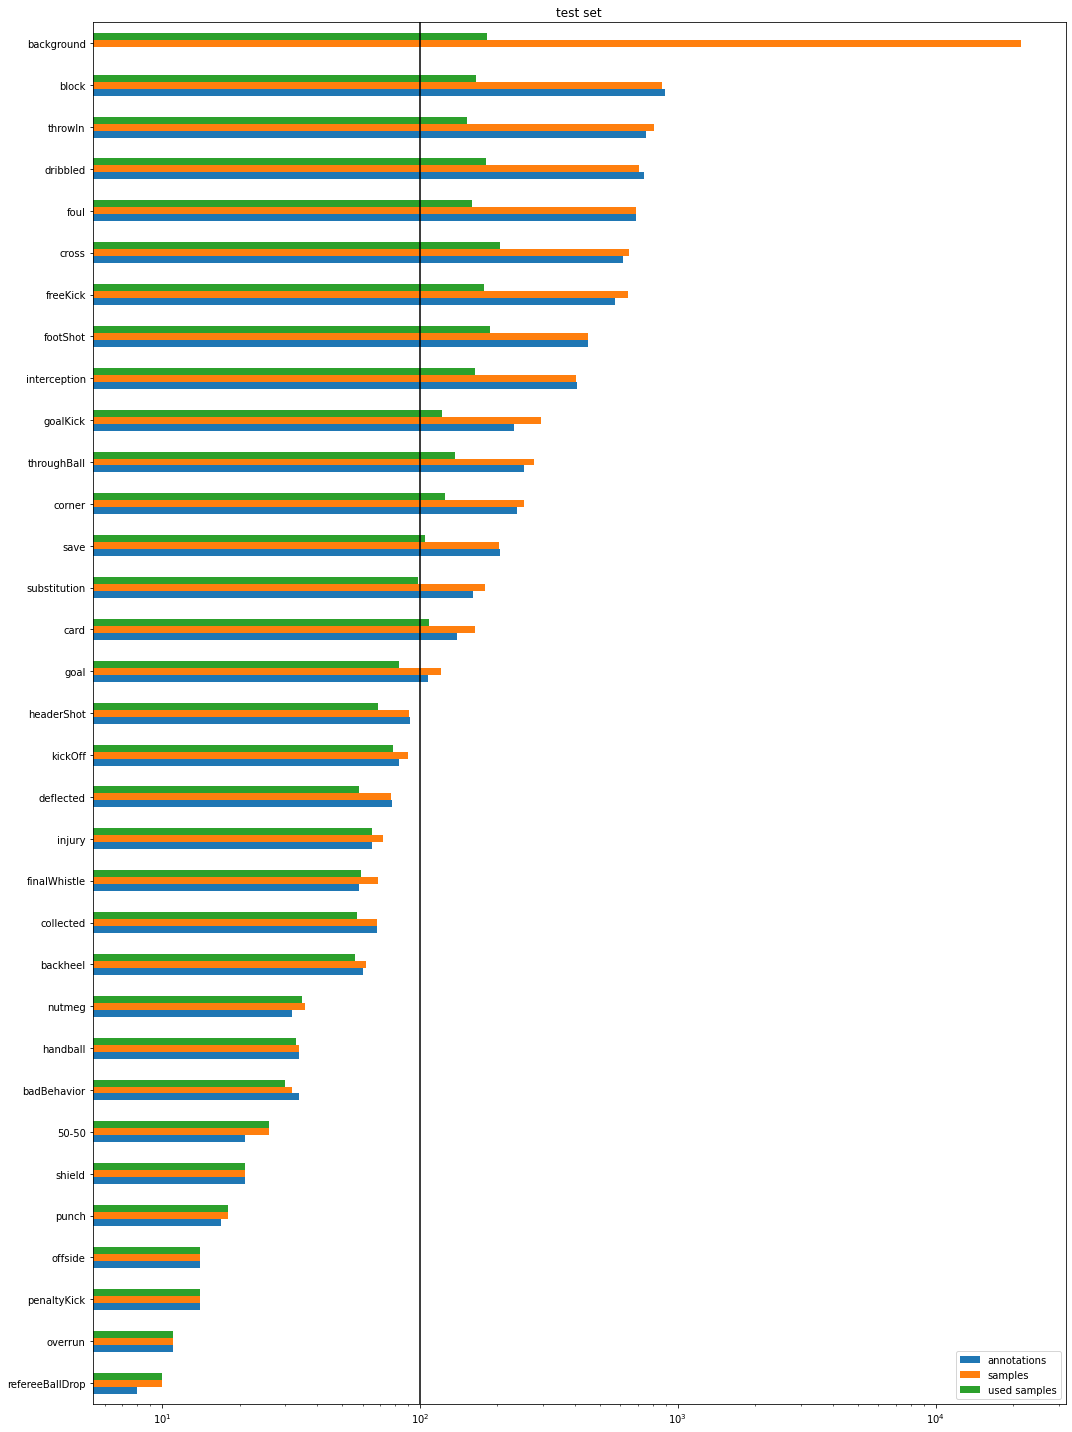

In [ ]:
eval.plot_distribution(context='test', save=True, upload=True)

In [ ]:
plot = eval.get_sample_plot(context='test')
from ipywidgets import HTML
HTML(plot.show('sample'))

row set to 23615 by random choice


HTML(value='<video width="864" height="576" controls autoplay loop>\n  <source type="video/mp4" src="data:vide…

In [ ]:
plot.save('svg')
plot.save('gif')

PosixPath('data/out/samples/ILpg4d2N@2:1992.0-1998.0.gif')

### Run evaluation



try avg and max consensus...

In [ ]:
module.hparams.consensus = 'max'
dm.batch_size = multi_clip_test_bs
trainer.test(module, dm.test_dataloader())

/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."
/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."
/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."
/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."
/usr/local/lib/python3.6/dis

input shape is torch.Size([1, 4, 3, 32, 224, 224])


ERROR:libav.h264:mmco: unref short failure
ERROR:libav.h264:mmco: unref short failure
ERROR:libav.h264:mmco: unref short failure
ERROR:libav.h264:mmco: unref short failure
ERROR:libav.h264:mmco: unref short failure
ERROR:libav.h264:mmco: unref short failure
ERROR:libav.h264:mmco: unref short failure



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(0.1478, device='cuda:0'),
 'val_acc_macro': tensor(0.9664, device='cuda:0'),
 'val_auroc_macro': 0.8531531347853635,
 'val_auroc_micro': 0.885864512969269,
 'val_balanced_acc_macro': tensor(0.6411, device='cuda:0'),
 'val_f1_macro': tensor(0.3050, device='cuda:0'),
 'val_hamming_loss': tensor(0.0336, device='cuda:0'),
 'val_loss': tensor(0.1149, device='cuda:0'),
 'val_precision_macro': tensor(0.3689, device='cuda:0'),
 'val_recall_macro': tensor(0.2926, device='cuda:0')}
--------------------------------------------------------------------------------


[{'test_loss': 0.1478109359741211,
  'val_acc_macro': 0.9663671255111694,
  'val_auroc_macro': 0.8531531347853635,
  'val_auroc_micro': 0.885864512969269,
  'val_balanced_acc_macro': 0.6411123871803284,
  'val_f1_macro': 0.30500298738479614,
  'val_hamming_loss': 0.033632874488830566,
  'val_loss': 0.11492390185594559,
  'val_precision_macro': 0.36892518401145935,
  'val_recall_macro': 0.29262977838516235}]

upload report...

In [ ]:
report_path = reporter.report_file
f'saved report at {report_path}'

'saved report at data/out/irCSN_152_32T_12fps/report.csv'

In [ ]:
res = logger.experiment.log_asset(report_path, overwrite=True)
res

{'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=af2fefd153ad47929d71277fa4c94e94&experimentKey=13f864626d1447fdb546adf3939c5431',
 'assetId': 'af2fefd153ad47929d71277fa4c94e94',
 'web': 'https://www.comet.ml/api/asset/download?assetId=af2fefd153ad47929d71277fa4c94e94&experimentKey=13f864626d1447fdb546adf3939c5431'}

## 7. Report Evaluation

In [ ]:
from socc_har.eval import ReportEvaluationModule
import pandas as pd
df = pd.read_csv(report_path)
eval = ReportEvaluationModule(out_path, dm, df, logger, consensus='max')

In [ ]:
f'got report containing {eval.num_epochs} epochs and {eval.num_test_runs} tests (epoch={eval.last_test_epoch})'

'got report containing 3 epochs and 0 tests (epoch=nan)'

In [ ]:
assert eval.integrity_check()

In [ ]:
df = eval.report

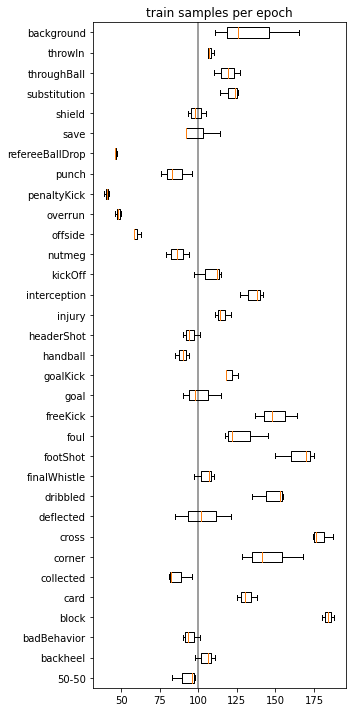

In [ ]:
fig = eval.train_samples_boxplot(True, True)
fig

log train metrics
log val metrics


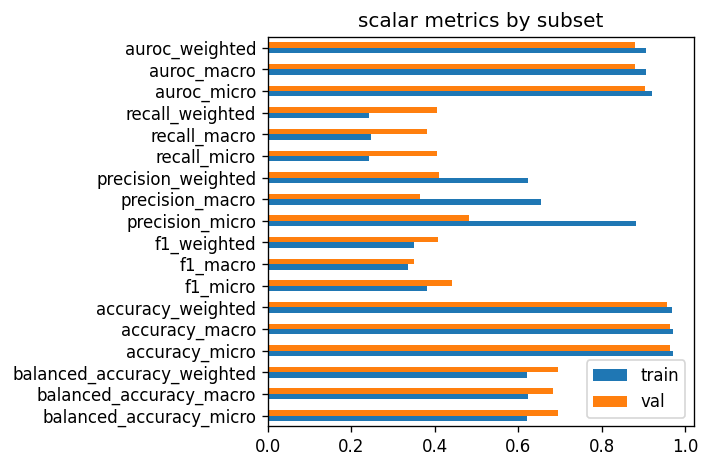

In [ ]:
fig, metrics = eval.get_scalars(save=True, upload=True)
fig

In [ ]:
logger.experiment.log_figure('metrics', fig)

{'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=5b88ce6399b44a69b8968a00f4c2dc80&experimentKey=fbc20481084445ea941b7152082e19e1',
 'imageId': '5b88ce6399b44a69b8968a00f4c2dc80',
 'web': 'https://www.comet.ml/api/image/download?imageId=5b88ce6399b44a69b8968a00f4c2dc80&experimentKey=fbc20481084445ea941b7152082e19e1'}

50-50
backheel
badBehavior
block
card
collected
corner
cross
deflected
dribbled
finalWhistle
footShot
foul
freeKick
goal
goalKick
handball
headerShot
injury
interception
kickOff
nutmeg
offside
overrun
penaltyKick
punch
refereeBallDrop
save
shield
substitution
throughBall
throwIn


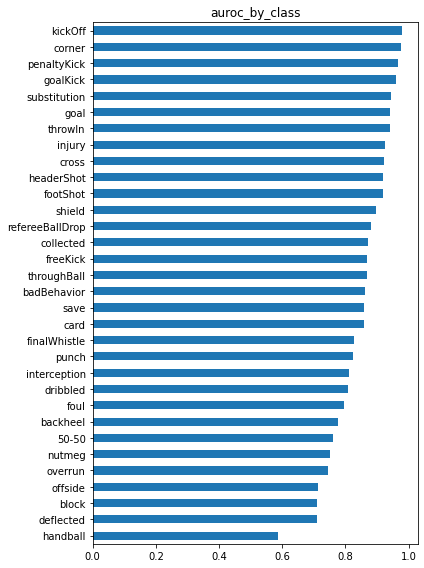

In [ ]:
fig, _ = eval.get_scalar_by_class('test', 'auroc', save=True, upload=True)
fig

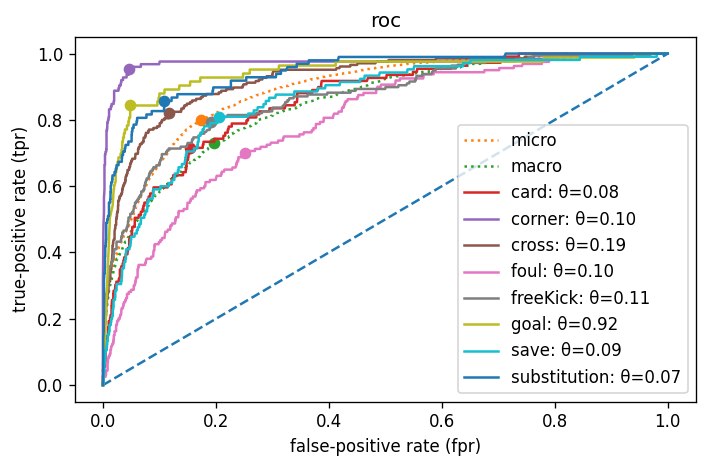

In [ ]:
fig, _ = eval.get_curve(split='test', metric='roc', reductions=['micro', 'macro'], classes=['foul', 'card', 'freeKick', 'substitution', 'cross', 'save', 'corner', 'goal'], save=True, upload=True)
fig

50-50
backheel
badBehavior
block
card
collected
corner
cross
deflected
dribbled
finalWhistle
footShot
foul
freeKick
goal
goalKick
handball
headerShot
injury
interception
kickOff
nutmeg
offside
overrun
penaltyKick
punch
refereeBallDrop
save
shield
substitution
throughBall
throwIn


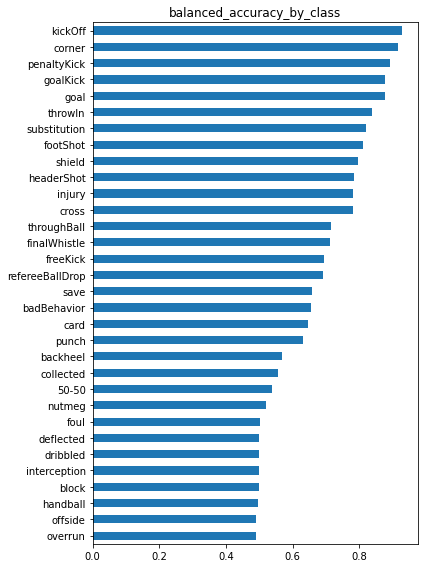

In [ ]:
fig, _ = eval.get_scalar_by_class('test', 'balanced_accuracy', save=True, upload=True)
fig

50-50
backheel
badBehavior
block
card
collected
corner
cross
deflected
dribbled
finalWhistle
footShot
foul
freeKick
goal
goalKick
handball
headerShot
injury
interception
kickOff
nutmeg
offside
overrun
penaltyKick
punch
refereeBallDrop
save
shield
substitution
throughBall
throwIn


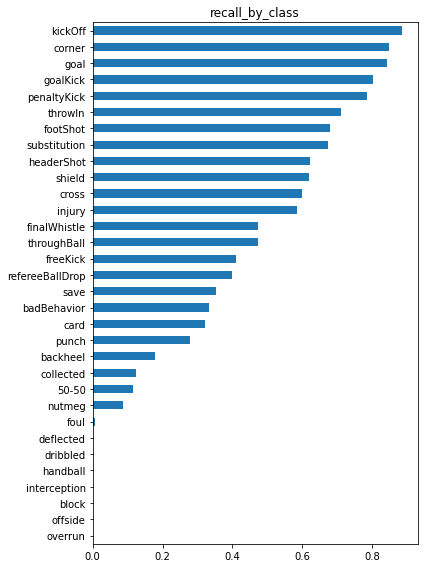

In [ ]:
fig, _ = eval.get_scalar_by_class('test', 'recall', save=True, upload=True)
fig

50-50
backheel
badBehavior
block
card
collected
corner
cross
deflected
dribbled
finalWhistle
footShot
foul
freeKick
goal
goalKick
handball
headerShot
injury
interception
kickOff
nutmeg
offside
overrun
penaltyKick
punch
refereeBallDrop
save
shield
substitution
throughBall
throwIn


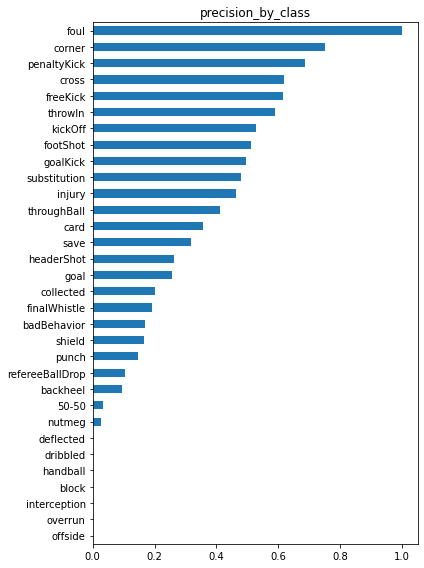

In [ ]:
fig, _ = eval.get_scalar_by_class('test', 'precision', save=True, upload=True)
fig

50-50
backheel
badBehavior
block
card
collected
corner
cross
deflected
dribbled
finalWhistle
footShot
foul
freeKick
goal
goalKick
handball
headerShot
injury
interception
kickOff
nutmeg
offside
overrun
penaltyKick
punch
refereeBallDrop
save
shield
substitution
throughBall
throwIn


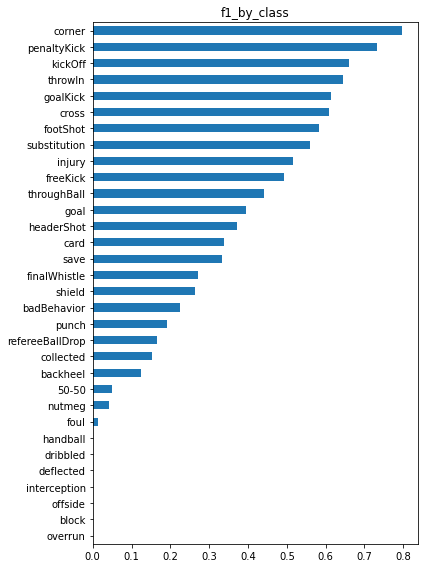

In [ ]:
fig, _ = eval.get_scalar_by_class('test', 'f1', save=True, upload=True)
fig

In [ ]:
eval.get_threshold_by_metric('test', 'balanced_accuracy', 'weighted', save=True, upload=True)

(<Figure size 720x480 with 1 Axes>,
 {'threshold_by_balanced_accuracy_weighted': tensor(0.1100)})

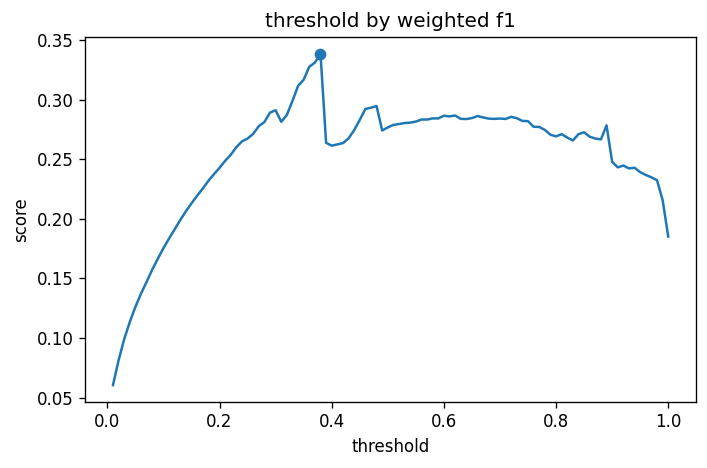

In [ ]:
eval.get_threshold_by_metric('test', 'f1', 'weighted', save=True, upload=True)